In [1]:
## Loading the MHA and MQA models

import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer,AutoModelForCausalLM

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
## Models
MHA_MODEL = "gpt2-medium"
MQA_MODEL = "tiiuae/falcon-rw-1b"

## Tokenizers
tokenizer_mha = AutoTokenizer.from_pretrained(MHA_MODEL)
tokenizer_mqa = AutoTokenizer.from_pretrained(MQA_MODEL)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [40]:
prompt = "Bright stars shimmer gently above calm seas at night."

def get_attn_output(model_name,tokenizer,prompt):
    print(f"\nLOADING MODEL : {model_name}")
    model = AutoModelForCausalLM.from_pretrained(model_name,
                                                 torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                                                 low_cpu_mem_usage=True,
                                                 output_attentions=True
                                                 )
    model.to(device)
    model.eval()
    inputs = tokenizer(prompt,return_tensors="pt").to(device)
    with torch.no_grad():
        start_time = time.time()
        outputs = model(**inputs)
        end_time = time.time()
    latency = end_time - start_time
    return outputs.attentions,model,inputs,latency

In [41]:
## Run MHA Model
attn_mha , model_mha , _,time_mha = get_attn_output(MHA_MODEL,tokenizer_mha,prompt)
torch.cuda.empty_cache()

## Run MQA Model
attn_mqa , model_mqa , _,time_mqa = get_attn_output(MQA_MODEL,tokenizer_mha,prompt)
torch.cuda.empty_cache()

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



LOADING MODEL : gpt2-medium

LOADING MODEL : tiiuae/falcon-rw-1b


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [42]:
print(f"Inference Time for MHA model : {time_mha:.3f} seconds")
print(f"Inference Time for MQA model : {time_mqa:.3f} seconds")

Inference Time for MHA model : 0.022 seconds
Inference Time for MQA model : 0.021 seconds


In [43]:
## Comparing attention score values for all heads 

def plot_heads(attn_scores,label,layer=-1):
    attn = attn_scores[layer][0].detach().cpu() # [num_heads,seq_len,seq_len]
    num_heads = attn.shape[0]
    seq_len   = attn.shape[1]
    cols = 4
    rows = (num_heads + cols-1)//cols
    fig,axes = plt.subplots(rows,cols,figsize=(cols*4,rows*4))
    fig.suptitle(f"Attention Maps - {label} (layer {layer})",fontsize=16)


    for i in range(rows*cols):
        r,c=divmod(i,cols)
        ax=axes[r,c] if rows>1 else axes[c]
        if i<num_heads : 
            sns.heatmap(attn[i],ax=ax,cmap='viridis',cbar=False)
            ax.set_title(f"Head {i}")
            ax.set_xlabel(f"Key")
            ax.set_ylabel(f"Query")
        else : 
            ax.axis("off")
    plt.tight_layout()
    plt.show()

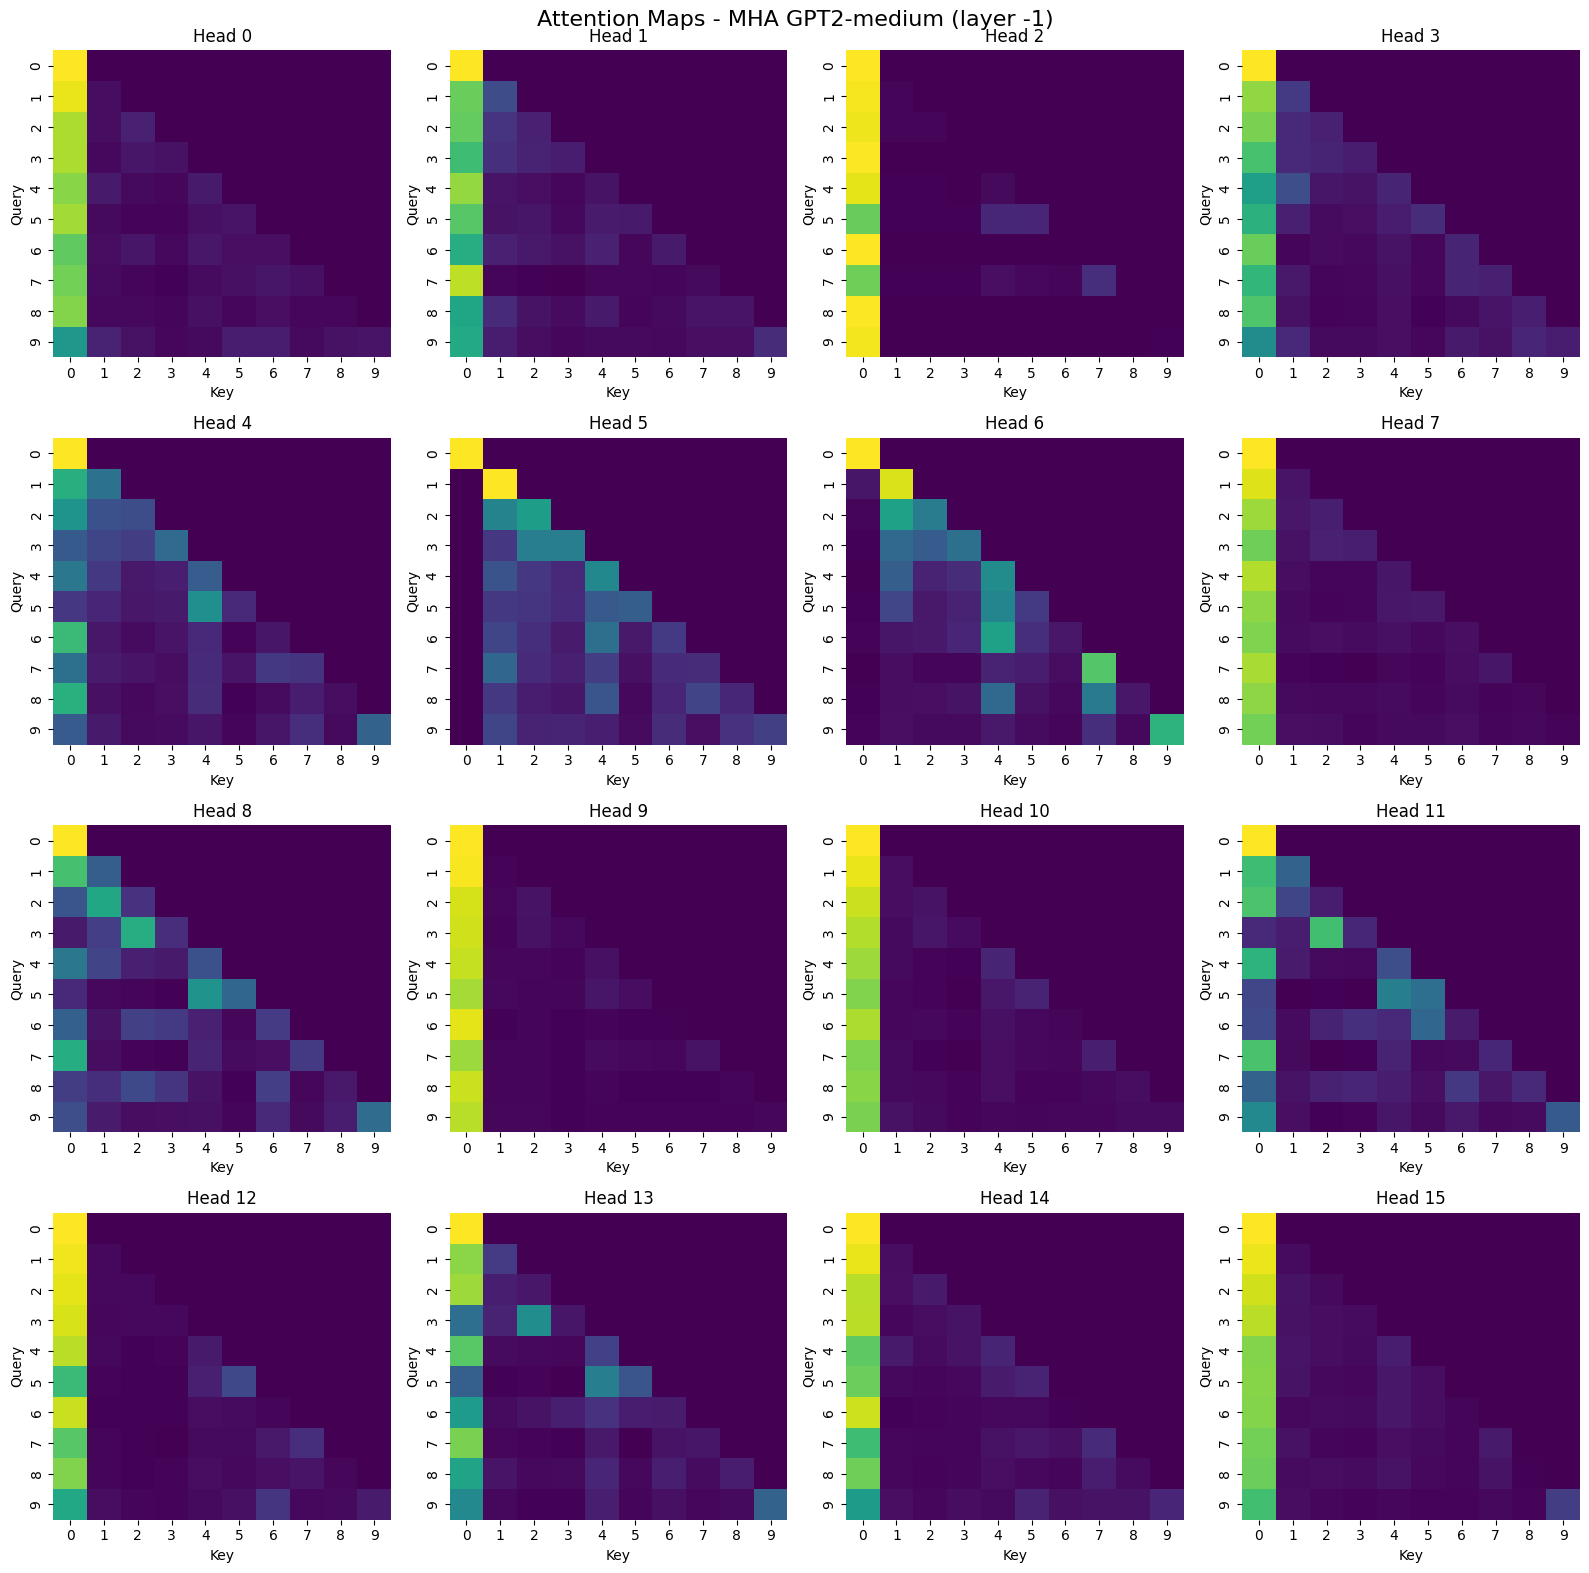

In [44]:
plot_heads(attn_mha,"MHA GPT2-medium")

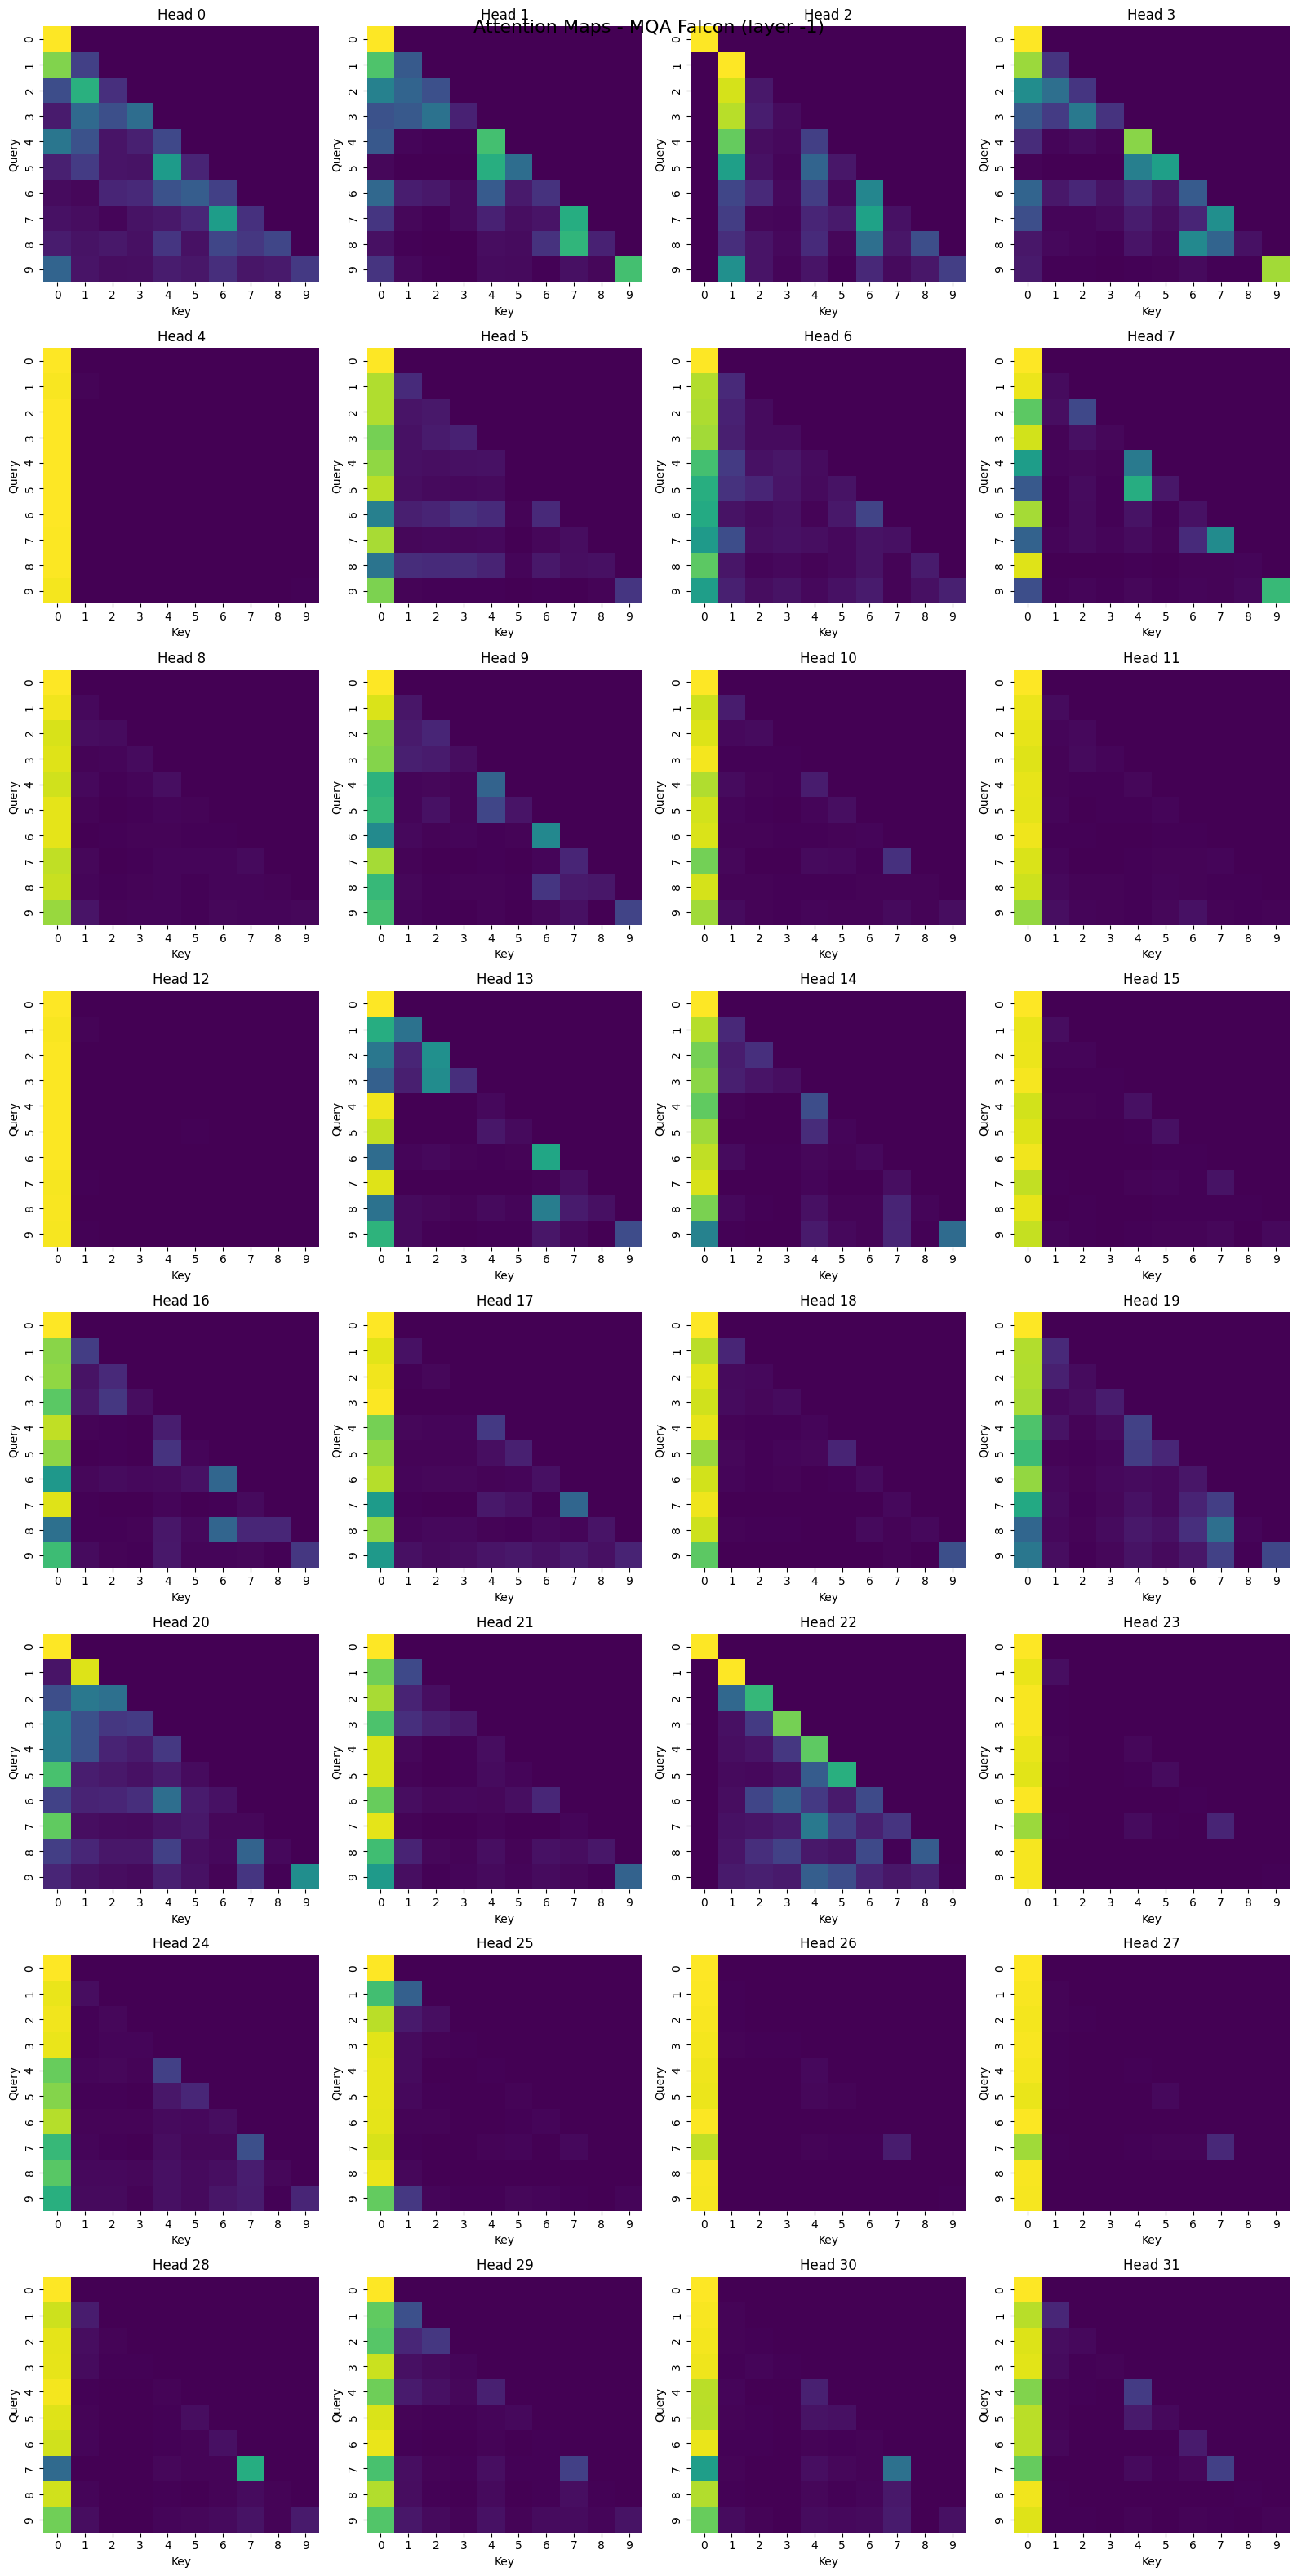

In [45]:
plot_heads(attn_mqa,"MQA Falcon")

In [24]:
def extract_falcon_KV_weights(model,layer_idx=0):
    layer = model.transformer.h[layer_idx]
    qkv_proj = layer.self_attention.query_key_value.weight.detach().cpu()
    w_q,w_k,w_v = torch.chunk(qkv_proj,3,dim=0)
    return w_k,w_v

In [19]:
def extract_gpt2_KV_weights(model,layer_idx=0):
    layer = model.transformer.h[layer_idx]
    qkv_proj = layer.attn.c_attn.weight.detach().cpu()
    w_q,w_k,w_v = torch.chunk(qkv_proj,3,dim=1)
    return w_k.T,w_v.T

In [21]:
try:
    w_k_mha , w_v_mha = extract_gpt2_KV_weights(model_mha)
    print(f"[GPT2-medium] Key shape: {w_k_mha.shape} , Value shape: {w_v_mha.shape}")
except Exception as e : 
    print(f"[GPT2-medium] Failed to extract KV : {e}")

[GPT2-medium] Key shape: torch.Size([1024, 1024]) , Value shape: torch.Size([1024, 1024])


In [27]:
try:
    w_k_mqa , w_v_mqa = extract_falcon_KV_weights(model_mqa)
    print(f"[Falcon] Key shape: {w_k_mha.shape} , Value shape: {w_v_mha.shape}")
except Exception as e : 
    print(f"[Falcon] Failed to extract KV : {e}")

[Falcon] Key shape: torch.Size([2048, 2048]) , Value shape: torch.Size([2048, 2048])


In [36]:
def Vis_KV_heads(w_k,w_v,num_heads,model_label):
    head_dim = w_k.shape[1] // num_heads
    print(f"\n {model_label} - Key Projections")
    for i in  range(min(6,num_heads)):
        head_k = w_k[:,i*head_dim:(i+1)*head_dim]
        plt.figure(figsize=(6,1.5))
        sns.heatmap(head_k[:50],cmap='coolwarm',cbar=False)
        plt.title(f"{model_label} - Key Head {i}")
        plt.show()

    print(f"\n {model_label} - Value Projiections")
    for i in  range(min(6,num_heads)):
        head_v = w_v[:,i*head_dim:(i+1)*head_dim]
        plt.figure(figsize=(6,1.5))
        sns.heatmap(head_v[:50],cmap='coolwarm',cbar=False)
        plt.title(f"{model_label} - Value Head {i}")
        plt.show()


 GPT2-medium (MHA) - Key Projections


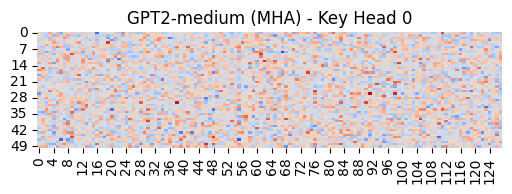

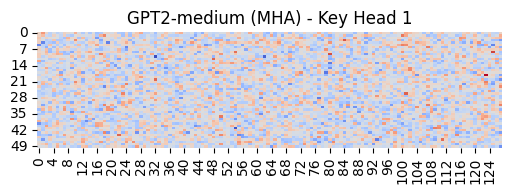

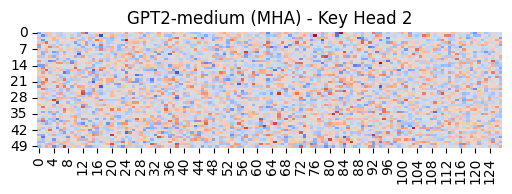

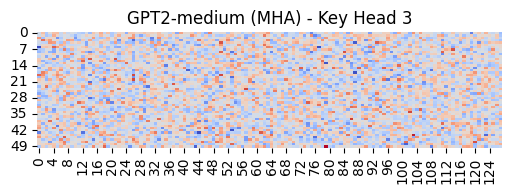

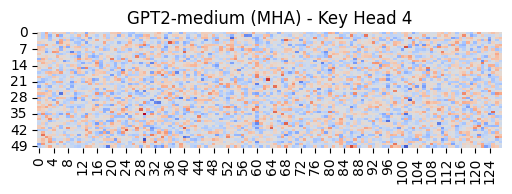

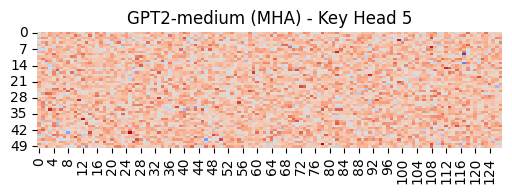


 GPT2-medium (MHA) - Value Projiections


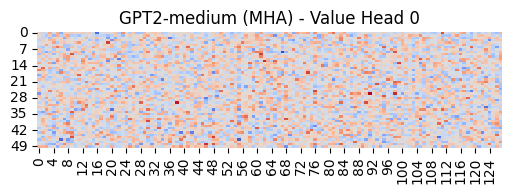

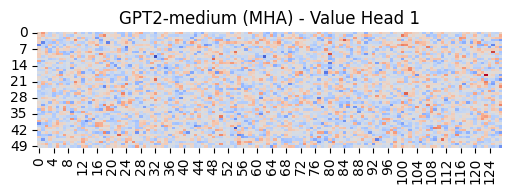

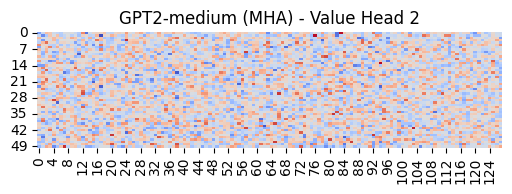

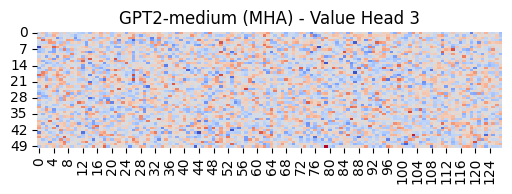

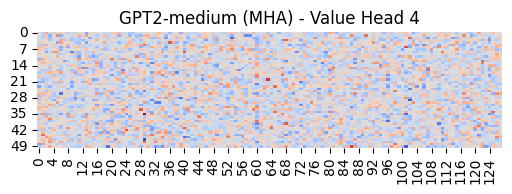

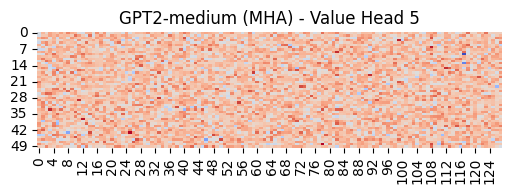

In [37]:
Vis_KV_heads(w_k_mha,w_k_mha,model_mha.config.n_head,"GPT2-medium (MHA)") ## visualize trainable matrices for diffrent Values and Keys heads


 Falcon (MQA) - Key Projections


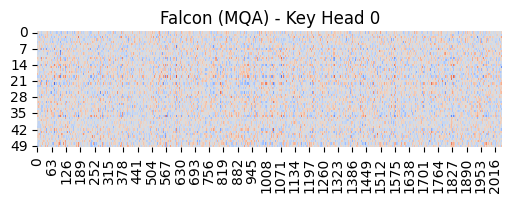

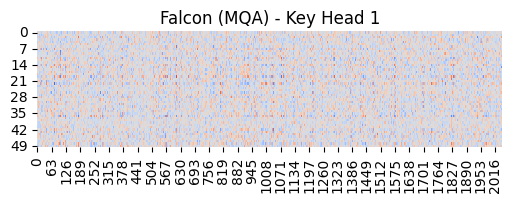

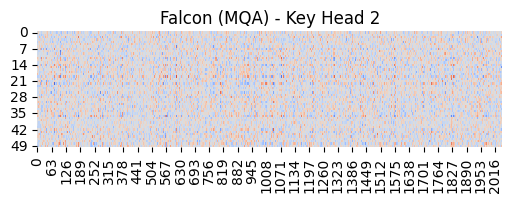

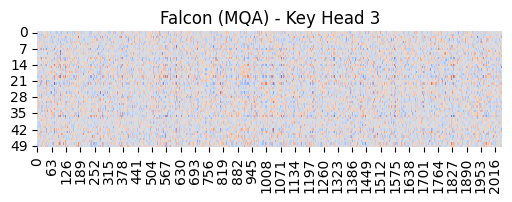

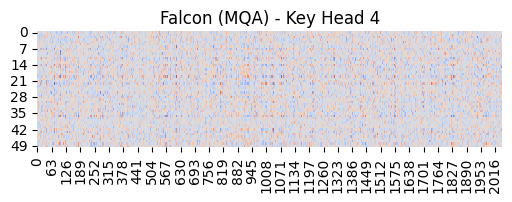

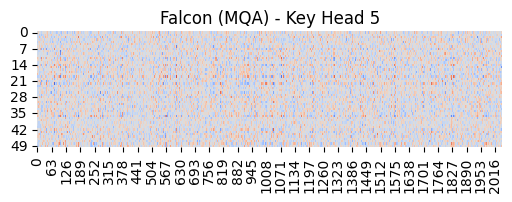


 Falcon (MQA) - Value Projiections


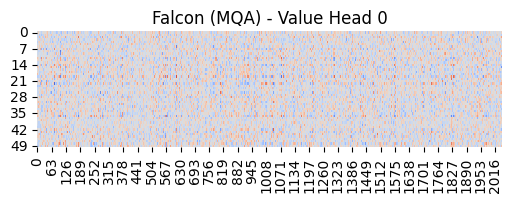

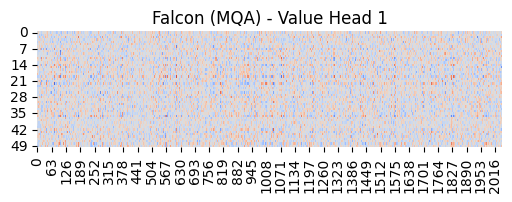

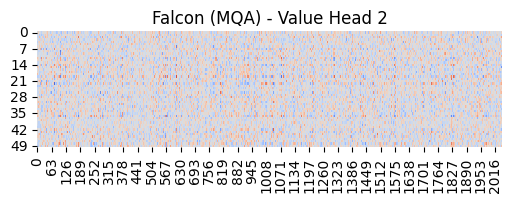

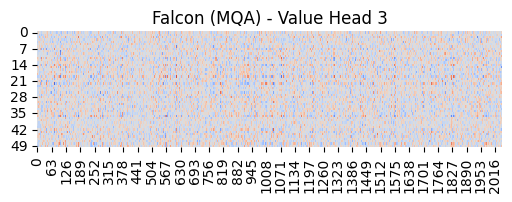

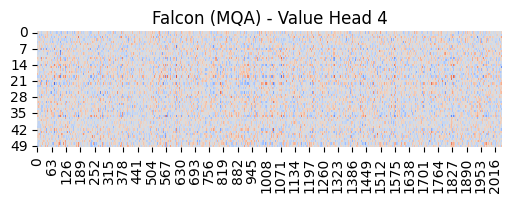

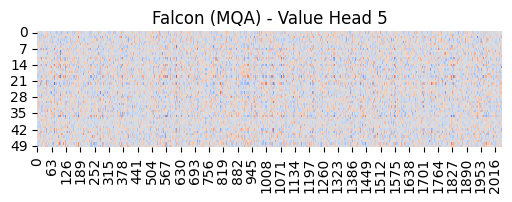

In [39]:
num_heads_mqa = model_mqa.config.num_attention_heads
w_k_mqa_repeated = w_k_mqa.repeat(1,num_heads_mqa // (w_k_mqa.shape[1] // model_mqa.config.hidden_size))
w_k_mqa_repeated = w_v_mqa.repeat(1,num_heads_mqa // (w_v_mqa.shape[1] // model_mqa.config.hidden_size))
Vis_KV_heads(w_k_mqa_repeated,w_k_mqa_repeated,num_heads_mqa,"Falcon (MQA)") ## visualize trainable matrices for diffrent Values and Keys heads